In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogsvscats/test/dogs/dog.375.jpg
/kaggle/input/dogsvscats/test/dogs/dog.704.jpg
/kaggle/input/dogsvscats/test/dogs/dog.8597.jpg
/kaggle/input/dogsvscats/test/dogs/dog.5740.jpg
/kaggle/input/dogsvscats/test/dogs/dog.5703.jpg
/kaggle/input/dogsvscats/test/dogs/dog.7717.jpg
/kaggle/input/dogsvscats/test/dogs/dog.2618.jpg
/kaggle/input/dogsvscats/test/dogs/dog.1956.jpg
/kaggle/input/dogsvscats/test/dogs/dog.5608.jpg
/kaggle/input/dogsvscats/test/dogs/dog.5646.jpg
/kaggle/input/dogsvscats/test/dogs/dog.7267.jpg
/kaggle/input/dogsvscats/test/dogs/dog.5341.jpg
/kaggle/input/dogsvscats/test/dogs/dog.7792.jpg
/kaggle/input/dogsvscats/test/dogs/dog.2888.jpg
/kaggle/input/dogsvscats/test/dogs/dog.3808.jpg
/kaggle/input/dogsvscats/test/dogs/dog.8388.jpg
/kaggle/input/dogsvscats/test/dogs/dog.10894.jpg
/kaggle/input/dogsvscats/test/dogs/dog.540.jpg
/kaggle/input/dogsvscats/test/dogs/dog.4190.jpg
/kaggle/input/dogsvscats/test/dogs/dog.1907.jpg
/kaggle/input/dogsvscats/test/dogs/dog.670

In [3]:
import os, pathlib, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1337) 
IMG_SIZE = (96, 96)     
BATCH_SIZE = 8

2025-09-26 07:41:06.710229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758872466.746434     130 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758872466.757108     130 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


import ve ayarlar

In [6]:
TRAIN_DIR = "/kaggle/input/dogsvscats/train"
TEST_DIR  = "/kaggle/input/dogsvscats/test"

# train'den %20 validation ayır
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
# test set zaten ayrı
test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Sınıflar:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.
Found 5000 files belonging to 2 classes.
Sınıflar: ['cats', 'dogs']


dataset hazırlanıp trainden %20 validation ayırdım, test klasörünü ayrı tuttum

In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

num_classes = len(class_names)

model = keras.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    layers.Rescaling(1./255),        # <--- NORMALIZATION BURADA
    data_augmentation,               # (opsiyonel ama puan kazandırır)
    layers.Conv2D(32, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,034 (6.61 MB)

 Trainable params: 1,732,034 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

resimler normalize edilip veri artırılıyor, CNN katmanları uygulanıyor, softmax çıkış katmanı olarak uygulanıyor

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 94ms/step - accuracy: 0.5586 - loss: 0.6845 - val_accuracy: 0.6875 - val_loss: 0.5885
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 174s 87ms/step - accuracy: 0.6796 - loss: 0.6009 - val_accuracy: 0.7235 - val_loss: 0.5316
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 173s 86ms/step - accuracy: 0.7253 - loss: 0.5482 - val_accuracy: 0.7563 - val_loss: 0.5018


model 3 epochta train verisiyle eğitiliyor ve performans validation seti üzerinde takip ediliyor.(hız açısından 3 epoch seçtim)

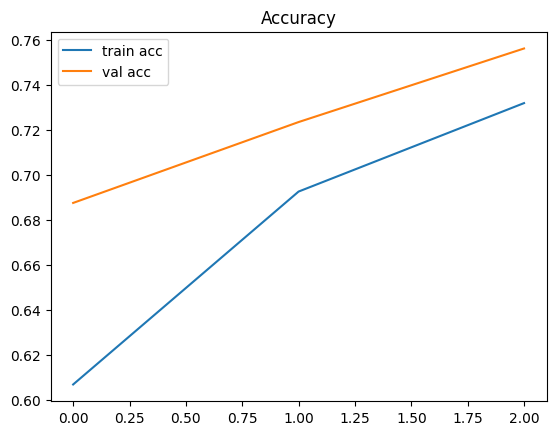

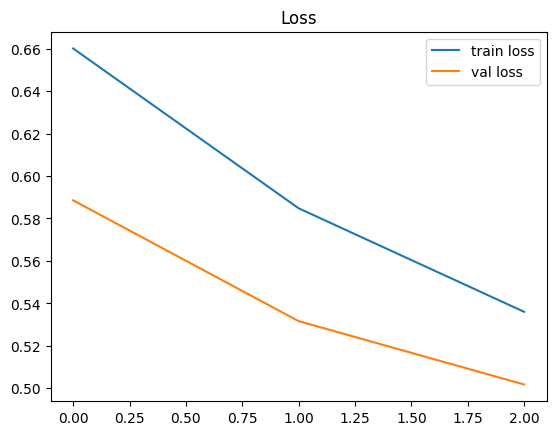

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("Loss"); plt.show()


 accuracy loss garfiği

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7419 - loss: 0.5560
Test acc: 0.7645999789237976
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step


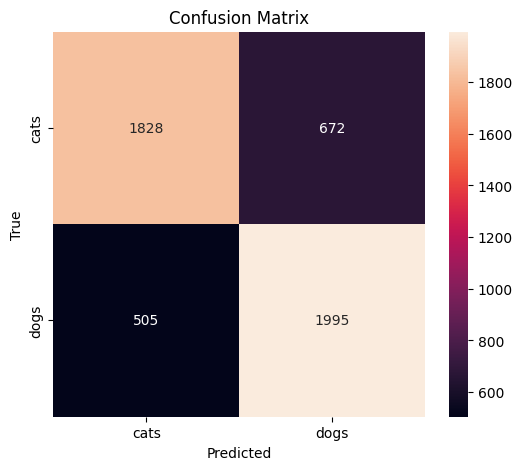

              precision    recall  f1-score   support

        cats       0.78      0.73      0.76      2500
        dogs       0.75      0.80      0.77      2500

    accuracy                           0.76      5000
   macro avg       0.77      0.76      0.76      5000
weighted avg       0.77      0.76      0.76      5000



In [10]:
# test skoru
test_loss, test_acc = model.evaluate(test_ds)
print("Test acc:", test_acc)

# confusion matrix için tahminler:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix"); plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


test seti başarımı ölçülüyor, tahminlerle birlikte confusion matrix ve classification report üretilerek sınıflandırma performansı detaylı inceleniyor

In [ ]:
model.summary()

Grad-CAM hedef katman: conv2d_2


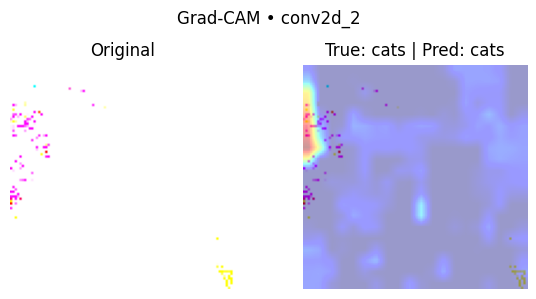

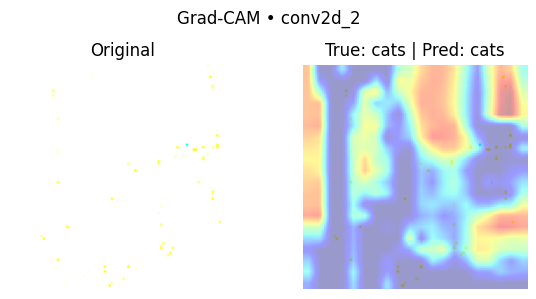

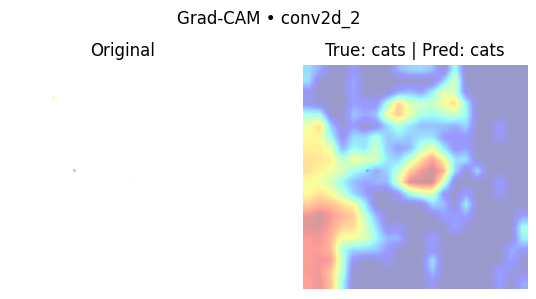

In [12]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt

def find_last_conv2d_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Modelde Conv2D katmanı bulunamadı.")

target_conv_name = find_last_conv2d_name(model)
print("Grad-CAM hedef katman:", target_conv_name)

def build_grad_model_via_forward(model, target_layer_name):
    assert isinstance(model, tf.keras.Sequential), "Bu fonksiyon Sequential modeller için yazıldı."
    inp = model.inputs[0]
    x = inp
    conv_feat = None

    for layer in model.layers:
        x = layer(x)                 # tensörü katmandan geçir
        if layer.name == target_layer_name:
            conv_feat = x            # hedef feature map'i hesapla

    if conv_feat is None:
        raise ValueError("Hedef katman ileri akışta bulunamadı.")
    return tf.keras.Model(inputs=inp, outputs=[conv_feat, x])

grad_model = build_grad_model_via_forward(model, target_conv_name)

def make_gradcam_heatmap(img_array, grad_model):
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array, training=False)  # conv_out:(1,H,W,C)
        class_idx = tf.argmax(preds[0])
        class_score = preds[:, class_idx]

    grads = tape.gradient(class_score, conv_out)                 # d(score)/d(feature)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))                 # kanal ağırlıkları
    conv_out = conv_out[0]                                       # (H,W,C)
    heat = tf.tensordot(conv_out, pooled, axes=(2,0))            # (H,W)
    heat = tf.maximum(heat, 0)
    heat = heat / (tf.reduce_max(heat) + 1e-8)
    return heat.numpy()

def show_gradcam_samples(ds, model, grad_model, class_names, num_images=3, target_hw=None):
    shown = 0
    if target_hw is None:
        try:
            target_hw = (model.input_shape[1], model.input_shape[2])
        except:
            target_hw = (128, 128)  

    for img, label in ds.unbatch():
        if shown >= num_images: break

        img_resized = tf.image.resize(img, target_hw)
        x = tf.expand_dims(img_resized, 0)  

        heat = make_gradcam_heatmap(x, grad_model)               # (H,W) 0..1

        # görseller
        orig = tf.cast(tf.clip_by_value(img*255.0, 0, 255), tf.uint8).numpy()
        heat_r = tf.image.resize(heat[...,None], (orig.shape[0], orig.shape[1]))[...,0].numpy()

        fig, ax = plt.subplots(1,2, figsize=(6,3))
        ax[0].imshow(orig); ax[0].axis("off"); ax[0].set_title("Original")
        ax[1].imshow(orig); ax[1].imshow(heat_r, cmap="jet", alpha=0.4); ax[1].axis("off")
        pred = np.argmax(model.predict(x, verbose=0), axis=1)[0]
        ax[1].set_title(f"True: {class_names[int(label.numpy())]} | Pred: {class_names[pred]}")
        plt.suptitle(f"Grad-CAM • {target_conv_name}")
        plt.tight_layout(); plt.show()
        shown += 1

show_gradcam_samples(test_ds, model, grad_model, class_names, num_images=3, target_hw=(96,96))


modelin son Conv2D katmanını hedefleyip Grad-CAM ısı haritaları çıkarıyor ve testten seçilen görsellerin üzerine bindirerek hangi bölgelere odaklanarak tahmin yaptığını gösteriyor. Ayrıca her görsel için gerçek ve tahmin etiketi başlıkta birlikte yazdırılıyor.

In [15]:
# --- Hızlı Hiperparametre Denemesi (1 epoch + mini subset) ---
import tensorflow as tf
from tensorflow.keras import layers, models

# CPU için küçük değerler:
IMG_SIZE = (96, 96)      
BATCH_SIZE = 8             

USE_SUBSET = True
SUBSET_TRAIN = 200
SUBSET_VAL   = 100


def subset_ds(ds, n, batch_size=BATCH_SIZE):
    return ds.unbatch().take(n).batch(batch_size)

train_fast = subset_ds(train_ds, SUBSET_TRAIN) if USE_SUBSET else train_ds
val_fast   = subset_ds(val_ds,   SUBSET_VAL)   if USE_SUBSET else val_ds

def build_model(dropout_rate=0.3):
    model = models.Sequential([
        layers.Input(shape=IMG_SIZE + (3,)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation="relu"), layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"), layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu"), layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(len(class_names), activation="softmax")
    ])
    return model

trials = [
    {"lr":1e-3, "drop":0.3},
    {"lr":5e-4, "drop":0.3},
    {"lr":5e-4, "drop":0.4},
]

results = []
for t in trials:
    m = build_model(dropout_rate=t["drop"])
    m.compile(optimizer=tf.keras.optimizers.Adam(t["lr"]),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    h = m.fit(train_fast, validation_data=val_fast, epochs=1, verbose=0)
    best_val = float(max(h.history["val_accuracy"]))
    results.append({**t, "best_val_acc": best_val})

results

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[{'lr': 0.001, 'drop': 0.3, 'best_val_acc': 0.5600000023841858},
 {'lr': 0.0005, 'drop': 0.3, 'best_val_acc': 0.5600000023841858},
 {'lr': 0.0005, 'drop': 0.4, 'best_val_acc': 0.5600000023841858}]